In [95]:

import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds


In [80]:
neutral_df = pd.read_csv('Neutral.csv',names=["TEXT"])
negative_df = pd.read_csv('Negative.csv',names=["TEXT"])
positive_df = pd.read_csv('Positive.csv',names=["TEXT"])

In [81]:
final_df = pd.concat([negative_df,neutral_df,positive_df])

In [82]:
final = final_df.values
final = np.reshape(final,(3865,))


In [83]:
labels = []
for i in range(len(negative_df)):
    labels.append(0)
for i in range(len(neutral_df)):
    labels.append(1)
for i in range(len(positive_df)):
    labels.append(2)
len(labels)

3865

In [130]:
BUFFER_SIZE = 5000
BATCH_SIZE = 100
TAKE_SIZE = 565

In [84]:
labeled_dataset = tf.data.Dataset.from_tensor_slices((final,labels))

In [85]:
for a,b in labeled_dataset.take(1):
    print(a.numpy()," ",b.numpy())
    print(a,b)

b'How unhappy  some dogs like it though'   0
tf.Tensor(b'How unhappy  some dogs like it though', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int32)


In [86]:
tokenizer = tfds.features.text.Tokenizer()

In [87]:
vocab_set = set()
for text,_ in labeled_dataset:
    tokens = tokenizer.tokenize(text.numpy())
    vocab_set.update(tokens)

vocab_size = len(vocab_set)
vocab_size

7367

In [88]:
encoder = tfds.features.text.TokenTextEncoder(vocab_set)

In [96]:
def encode_fn(text,label):
    encoded_text = encoder.encode(text.numpy())
    return encoded_text,label
def map_fn(text,label):
    return tf.py_function(encode_fn,inp=[text,label],Tout=(tf.int32,tf.int32))

encoded_labeled_data = labeled_dataset.map(map_fn)

In [107]:
encoded_labeled_data=encoded_labeled_data.shuffle(buffer_size=BUFFER_SIZE)

In [114]:
vocab_size+=1
vocab_size

7369

In [131]:
train_data = encoded_labeled_data.skip(TAKE_SIZE).padded_batch(BATCH_SIZE,padded_shapes=([-1],[]))
test_data = encoded_labeled_data.take(TAKE_SIZE).padded_batch(BATCH_SIZE,padded_shapes=([-1],[]))

In [132]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(3,activation='sigmoid')
])

In [133]:
model.compile(optimizer='adam',metrics=['accuracy'],loss='sparse_categorical_crossentropy')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 20)          147380    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                6560      
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 93        
Total params: 155,263
Trainable params: 155,263
Non-trainable params: 0
_________________________________________________________________


In [134]:
history = model.fit(train_data,epochs=5,validation_data=test_data)

Epoch 1/5
33/33 [==============================].0976 - accuracy: 0.28 - 5s 2s/step - loss: 1.0989 - accuracy: 0.25 - 5s 2s/step - loss: 1.0991 - accuracy: 0.25 - 5s 1s/step - loss: 1.0985 - accuracy: 0.29 - 5s 1s/step - loss: 1.0987 - accuracy: 0.31 - 5s 844ms/step - loss: 1.0987 - accuracy: 0.318 - 5s 726ms/step - loss: 1.0984 - accuracy: 0.331 - 5s 638ms/step - loss: 1.0982 - accuracy: 0.341 - 5s 569ms/step - loss: 1.0982 - accuracy: 0.341 - 5s 514ms/step - loss: 1.0976 - accuracy: 0.359 - 5s 470ms/step - loss: 1.0972 - accuracy: 0.367 - 5s 432ms/step - loss: 1.0966 - accuracy: 0.379 - 5s 401ms/step - loss: 1.0967 - accuracy: 0.376 - 5s 374ms/step - loss: 1.0965 - accuracy: 0.375 - 5s 350ms/step - loss: 1.0963 - accuracy: 0.377 - 5s 329ms/step - loss: 1.0962 - accuracy: 0.376 - 5s 311ms/step - loss: 1.0959 - accuracy: 0.378 - 5s 295ms/step - loss: 1.0954 - accuracy: 0.381 - 5s 280ms/step - loss: 1.0954 - accuracy: 0.380 - 5s 267ms/step - loss: 1.0954 - accuracy: 0.377 - 5s 256ms/ste

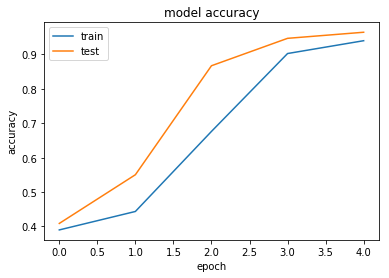

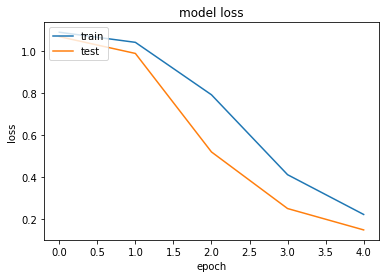

In [141]:
import matplotlib.pyplot as plt
history.history.keys()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()